In [1]:
import json 
path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_hierarchical_covariates_shared_False_use_subset_features_False_combined_results_sequential.json"
with open(path) as f:
    all_results = json.load(f)

In [2]:
# Insights 
# High-level model does worse when the covariates are shared across modules surprisingly

In [2]:
all_results

{'0.7': {'Baseline_train': [0.3768209056360677, 0.8942479718143597],
  'Baseline_test': [7.810683787230423, -0.03898948644215805],
  'Catenets_train': [0.6953517683370647, 0.8048546173944611],
  'Catenets_test': [32.15730644040114, -3.2776156626003514],
  'End_to_End_train': [1.0608923897418612, 0.7022683183871257],
  'End_to_End_test': [4.294811641856064, 0.42869737609489134],
  'Sequential_train': [0.13056127106142734, 0.9633589352110522],
  'Sequential_test': [0.4128057907542326, 0.9450879221051948]},
 '0.4': {'Baseline_train': [1.126997619262643, 0.7911061994712412],
  'Baseline_test': [6.216358596791839, 0.19792801175733665],
  'Catenets_train': [1.595880020578437, 0.7041968527807041],
  'Catenets_test': [10.051424047613521, -0.29689520721989004],
  'End_to_End_train': [1.0988861162909993, 0.7963167860722707],
  'End_to_End_test': [1.5808054023081823, 0.7960349757318665],
  'Sequential_train': [0.1050651483428675, 0.9805257280358597],
  'Sequential_test': [0.16020691594990727, 0.9

In [3]:
# # Hypotheses to test
# # 1. Each component output is a quadratic function of the input features.
# # 2. Plot final output vs input features.

# # Hypothesis 1
# # plot 1
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style="whitegrid")
# sns.set_context("talk")
# max_modules = args.num_modules
# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
# for i in range(max_modules):
#     sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
#     ax[i].set_title(f"Module {i}")

# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
# for i in range(max_modules):
#     sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
#     ax[i].set_title(f"Module {i}")

# # Have a 3D plot for two features and one output
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [15]:
all_results

{'0.7': {'Baseline_train': [0.3768209056360677, 0.8942479718143597],
  'Baseline_test': [7.810683787230423, -0.03898948644215805],
  'Catenets_train': [0.6953517683370647, 0.8048546173944611],
  'Catenets_test': [32.15730644040114, -3.2776156626003514],
  'End_to_End_train': [1.0608923897418612, 0.7022683183871257],
  'End_to_End_test': [4.294811641856064, 0.42869737609489134],
  'Sequential_train': [0.13056127106142734, 0.9633589352110522],
  'Sequential_test': [0.4128057907542326, 0.9450879221051948]},
 '0.4': {'Baseline_train': [1.126997619262643, 0.7911061994712412],
  'Baseline_test': [6.216358596791839, 0.19792801175733665],
  'Catenets_train': [1.595880020578437, 0.7041968527807041],
  'Catenets_test': [10.051424047613521, -0.29689520721989004],
  'End_to_End_train': [1.0988861162909993, 0.7963167860722707],
  'End_to_End_test': [1.5808054023081823, 0.7960349757318665],
  'Sequential_train': [0.1050651483428675, 0.9805257280358597],
  'Sequential_test': [0.16020691594990727, 0.9

[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]


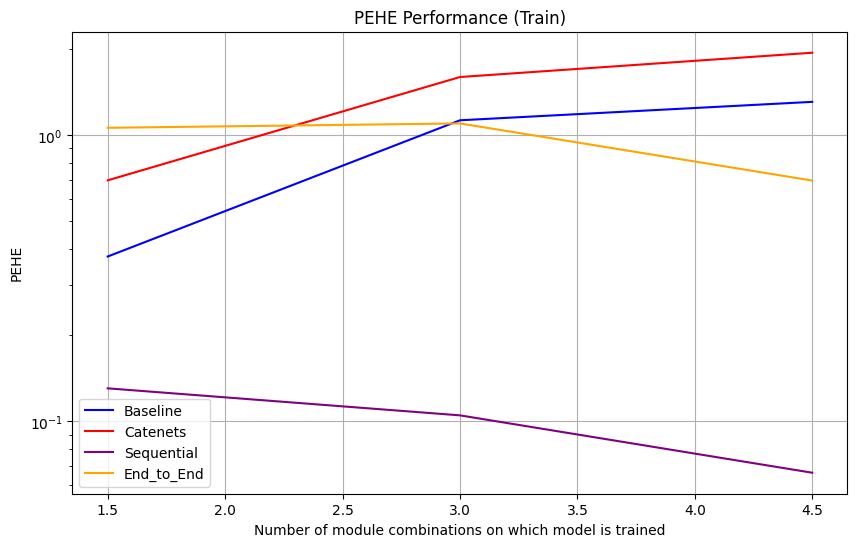

[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]


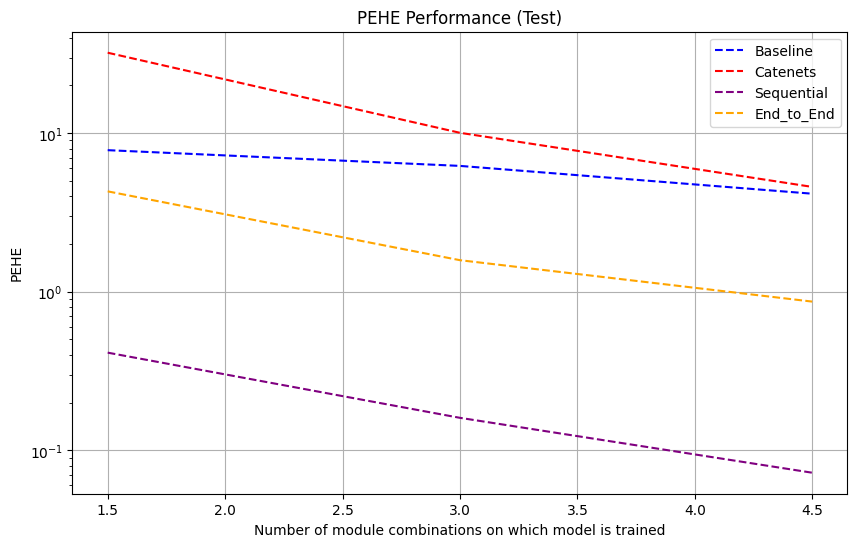

[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]


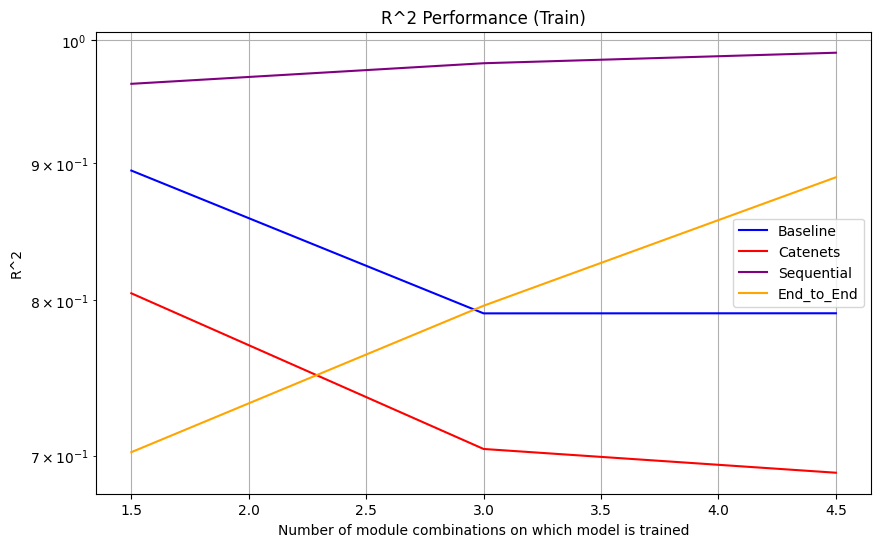

[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]
[0.3 0.6 0.9]
[1.5000000000000002, 3.0, 4.5]


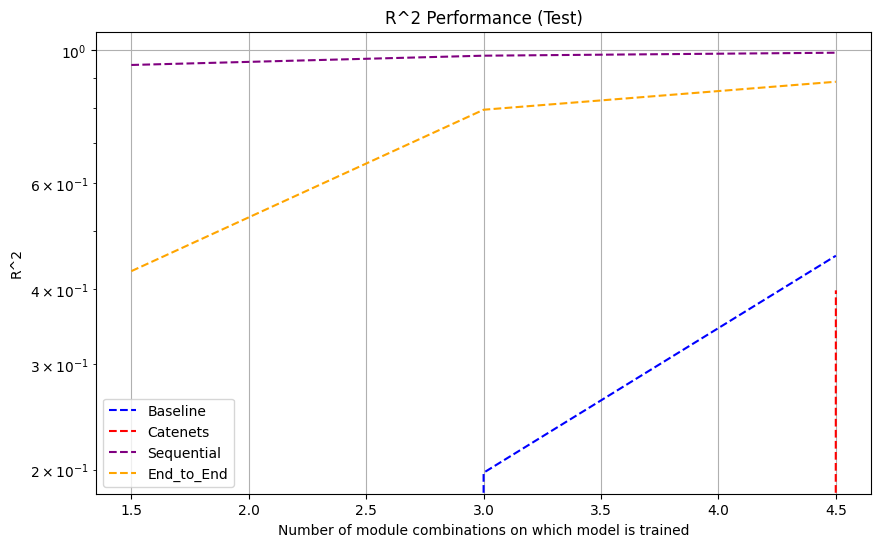

In [17]:
# Colors for each model
from matplotlib import pyplot as plt
import numpy as np
exp = "CG"
args = {}
args["number_of_modules"] = 5
import math
colors = {
    'Baseline': 'blue',
    'MoE': 'green',
    'Catenets': 'red',
    'Sequential': 'purple',
    'End_to_End': 'orange'
}

# Function to plot performance
def plot_performance(metric, metric_name, data_type):
    plt.figure(figsize=(10, 6))
    x = list(all_results.keys())
    # convert string to float
    x = [float(i) for i in x]
    # remove key 5
    # x = [i for i in x if i != 5]
   
    
    for model in ['Baseline', 'Catenets', 'Sequential', 'End_to_End']:
        y = [all_results[str(key)][f'{model}_{data_type}'][metric] for key in x]
        if exp == "noise":
            x_plot = np.array(x)
        else:
            x_plot = 1-np.array(x)
            print(x_plot)
            x_plot = [i*5 for i in x_plot]
        print(x_plot)
        plt.plot(x_plot, y, color=colors[model], label=model, 
                 linestyle='-' if data_type == 'train' else '--')
    
    plt.xlabel('Number of module combinations on which model is trained')
    plt.ylabel(metric_name)
    # y-axis in log scale
    plt.yscale('log')
    plt.title(f'{metric_name} Performance ({data_type.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot PEHE for train and test
plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test')

# Plot R^2 for train and test
plot_performance(1, 'R^2', 'train')
plot_performance(1, 'R^2', 'test')

In [9]:
# divide query output by number of non-zero modules
# divide query output by number of non-zero modules
num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
train_df['query_output'] = train_df['query_output'] / train_df[num_modules].sum(axis=1)
test_df['query_output'] = test_df['query_output'] / test_df[num_modules].sum(axis=1)

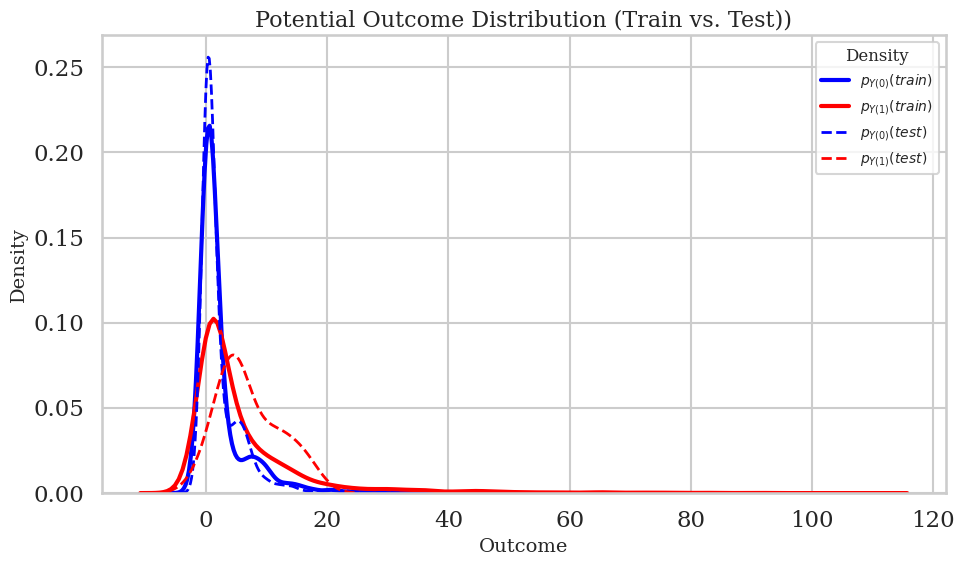

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(train)$'
    else:
        label = r'${p_{Y(1)}}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(test)$'
    else:
        label = r'${p_{Y(1)}}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Potential Outcome Distribution (Train vs. Test))", fontsize=16)
plt.xlabel("Outcome", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(train)$'
    else:
        label = r'${p_1}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(test)$'
    else:
        label = r'${p_1}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Covariate Distribution (Train vs. Test))", fontsize=16)
plt.xlabel(r'X', fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

ValueError: Could not interpret value `feature_0` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [28]:
train_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
0,3.287332,0.0,0.0,2.0,7.450842,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.721162
1,1.386121,1.0,1.0,2.0,2.614076,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.935652
2,1.449184,2.0,0.0,2.0,3.555470,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.946573
3,1.830773,3.0,1.0,2.0,3.415209,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.963807
4,3.214268,4.0,0.0,2.0,7.283298,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.725684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1.817987,1975.0,1.0,2.0,6.256585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.788571
1976,1.355247,1976.0,1.0,2.0,5.394947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.306489
1977,0.834129,1977.0,1.0,2.0,4.640085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.143926
1978,1.245059,1978.0,1.0,2.0,5.219637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.202561


In [29]:
test_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
1980,2.024449,1980.0,1.0,3.0,8.371116,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675675
1981,1.386121,1981.0,0.0,3.0,5.545832,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567783
1982,1.449184,1982.0,1.0,3.0,7.034041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570514
1983,1.830773,1983.0,1.0,3.0,7.928381,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625453
1984,3.214268,1984.0,1.0,3.0,10.883003,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.136444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17339,1.158450,17339.0,0.0,10.0,28.811296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.616271
17340,2.058481,17340.0,0.0,10.0,29.285012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.825939
17341,2.563185,17341.0,0.0,10.0,29.983296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.333226
17342,1.859517,17342.0,0.0,10.0,29.078769,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.001904


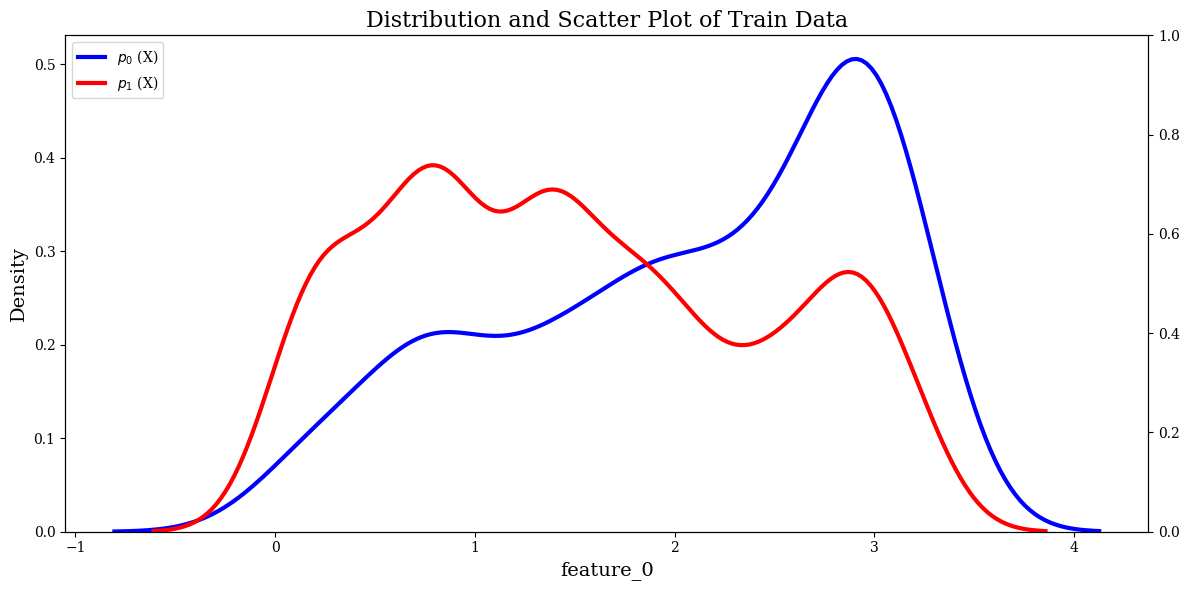

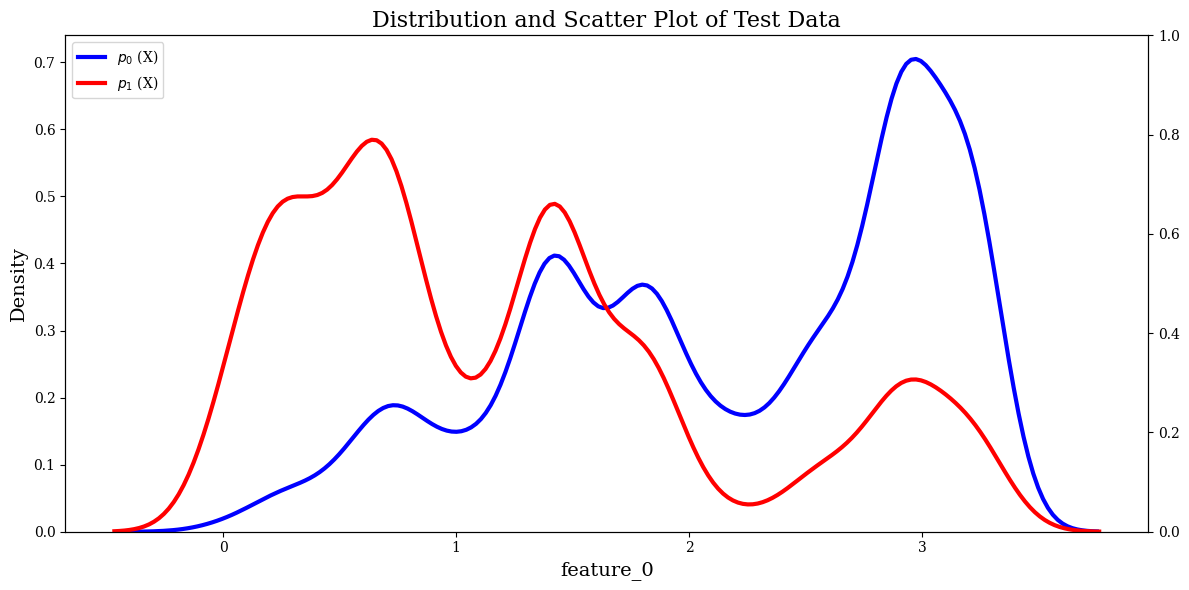

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.rcParams.update({
    "font.family": "serif",
})

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

def create_density_scatter_plot(data, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    for treatment in [0, 1]:
        subset = data[data['treatment_id'] == treatment]
        
        # Density plot for feature_0
        sns.kdeplot(data=subset, x='feature_0', ax=ax1, color=colors[treatment], 
                    linestyle='-', linewidth=3, 
                    label=r'$p_{}$ (X)'.format(treatment))
        
        # # Scatter plot
        # ax2.scatter(subset['feature_0'], subset['query_output'], 
        #             color=colors[treatment], alpha=0.3, s=10,
        #             label=r'$p_{}$ (query_output)'.format(treatment))
    
    ax1.set_xlabel("feature_0", fontsize=14)
    ax1.set_ylabel("Density", fontsize=14)
    # ax2.set_ylabel("query_output", fontsize=14)
    
    ax1.set_title(title, fontsize=16)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()

# Create plot for train data
create_density_scatter_plot(train_df, "Distribution and Scatter Plot of Train Data")
plt.show()

# Create plot for test data
create_density_scatter_plot(test_df, "Distribution and Scatter Plot of Test Data")
plt.show()

<Axes: xlabel='query_output', ylabel='Count'>

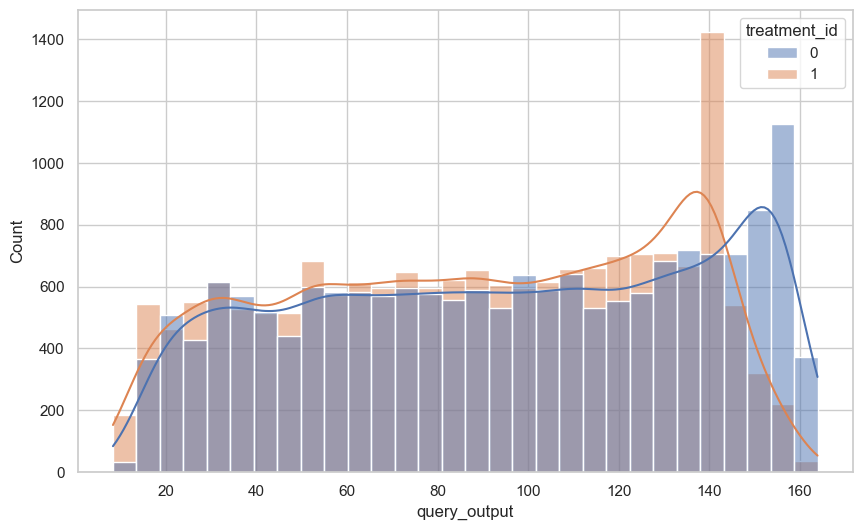

In [17]:
Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])

# plot the distribution of the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, x='query_output', hue='treatment_id', bins=30, kde=True)

In [9]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [10]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [12]:
for module_file, module_csv in module_csvs_test.items():
    module_id = int(module_file.split("_")[-1])
    print(f"Module {module_id}")
    pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
    print(f"PEHE: {pehe_score}")
    print(f"R2 Score: {r2_score(module_csv['ground_truth_effect'], module_csv['estimated_effect'])}")
    print("\n")

Module 1
PEHE: 8.43045680913006e-06
R2 Score: 0.9992116406238679


Module 3
PEHE: 3.409530403483242e-06
R2 Score: 0.9998127937246573


Module 2
PEHE: 2.948808966524245e-06
R2 Score: 0.9999532899051761




In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = data[["feature_0"]].values
# T = data[treatment].values
# Y = data[outcome].values
# Y_module = data[[f"module_{i}_output" for i in range(1, args.num_modules + 1)]].values
# X_T = np.concatenate([X, T.reshape(-1, 1)], axis=1)
# X_T = torch.tensor(X_T, dtype=torch.float32).to(device)
# expert_outputs = torch.stack([expert(X_T) for expert in model.experts], dim=1)
# gate_outputs = model.gate(X_T)
# expert_gate_multiplication = expert_outputs.squeeze(-1) * gate_outputs
# print(expert_outputs.shape, Y_module.shape, expert_gate_multiplication.shape)


In [13]:
# for i in range(6):
#     data["expert_output_" + str(i)] = expert_gate_multiplication[:, i].detach().cpu().numpy()

covariates

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [6]:
# data["final_output"] = final_output.squeeze(0).detach().cpu().numpy()

# # scatter plot for final output and query output
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x="query_output", y="final_output", data=data)
# plt.xlabel("Query Output")
# plt.ylabel("Final Output")
# plt.title("Final Output vs Query Output")
# plt.show()

<AxesSubplot:xlabel='feature_0', ylabel='query_output'>

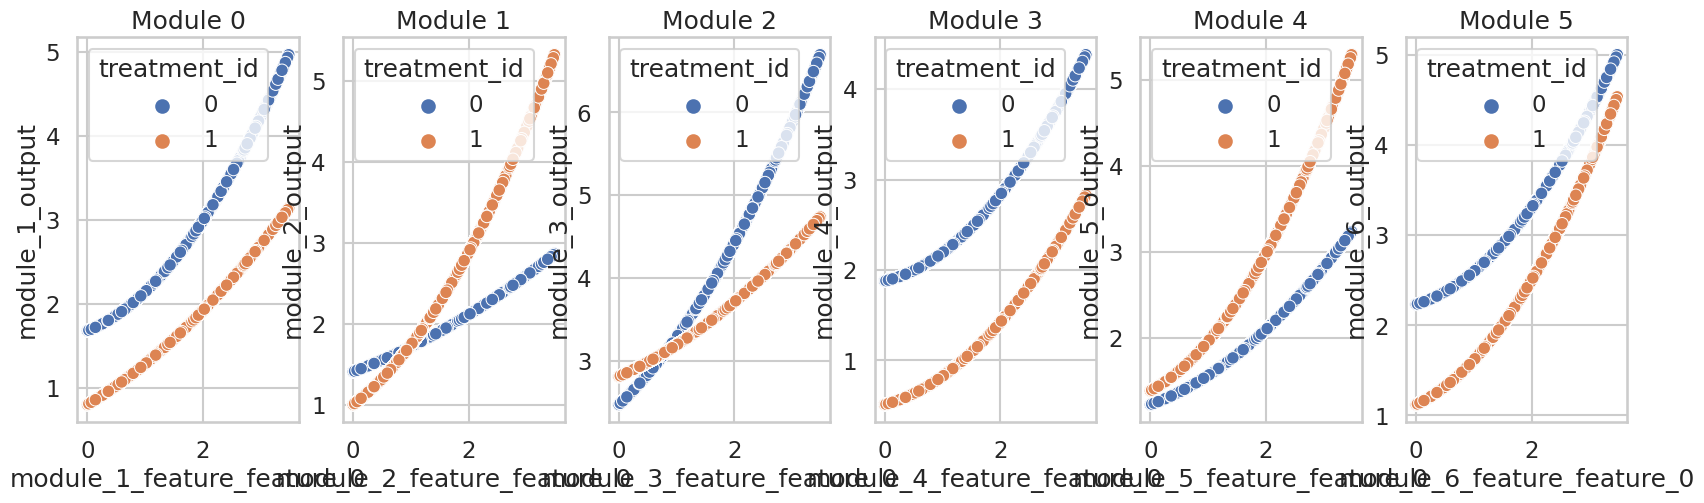

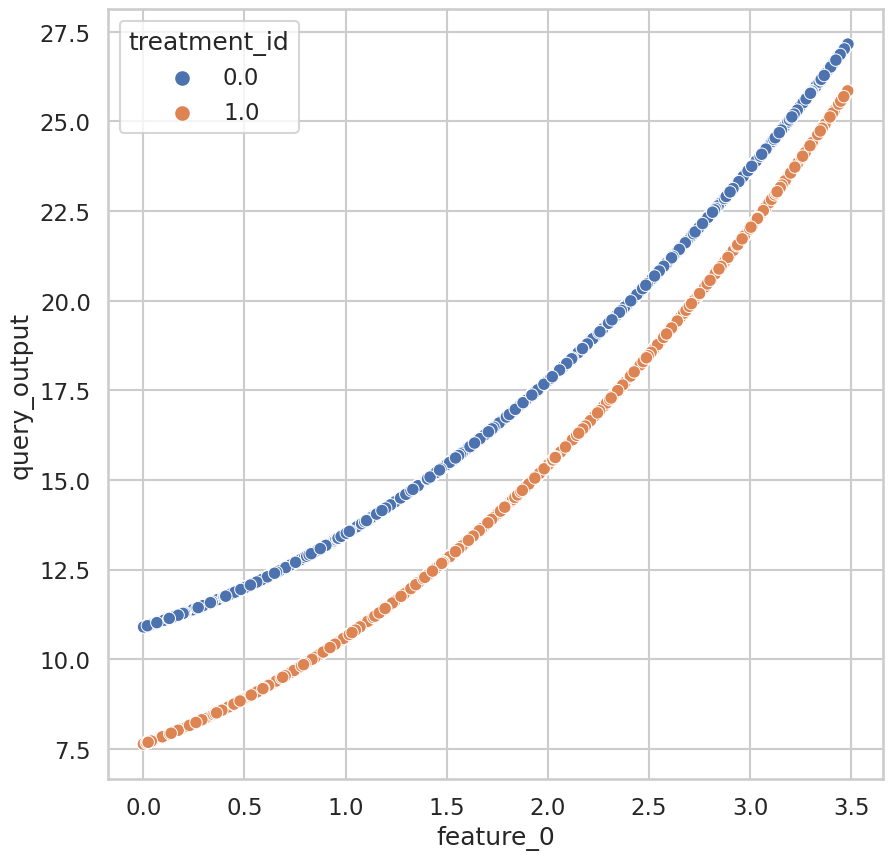

In [ ]:
# plot distribution of the covariates for train df with treatment id
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data=train_df, x="feature_0", hue="treatment_id", label="Train", color="blue", ax=ax[0])
ax[0].set_title("Train Distribution")
sns.kdeplot(data=test_df, x="feature_0", hue="treatment_id", label="Test", color="red", ax=ax[1])
ax[1].set_title("Test Distribution")


plt.title("Train Distribution")
plt.show()

In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")


plt.title("Train Distribution")
plt.show()





In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

2024-09-22 03:07:47.829116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Expectation Analysis for Different Composition Models 

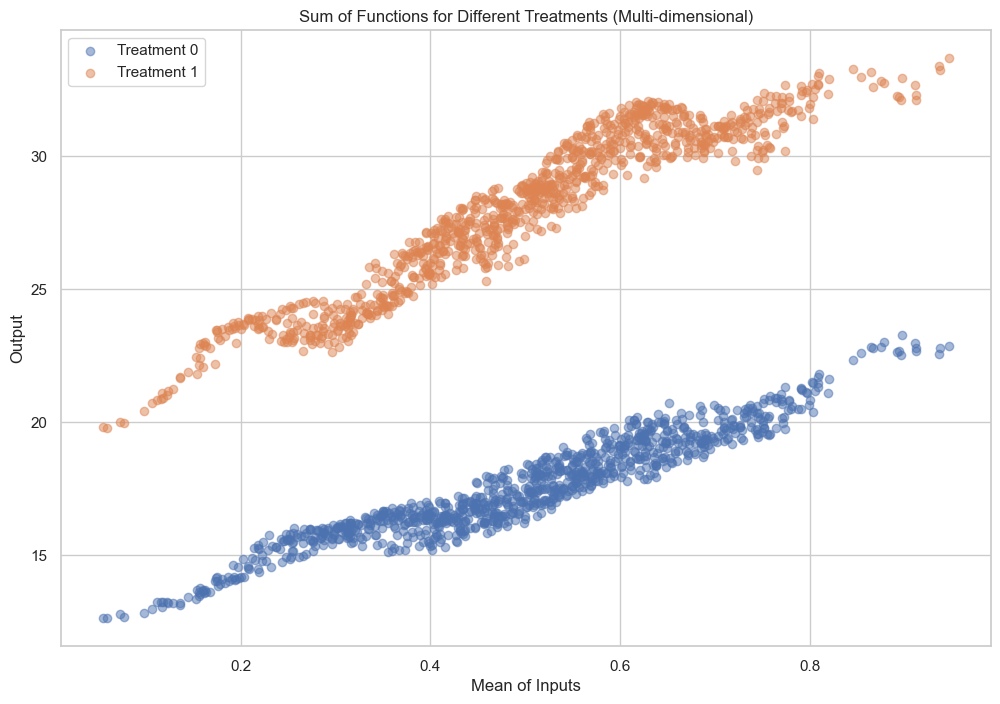

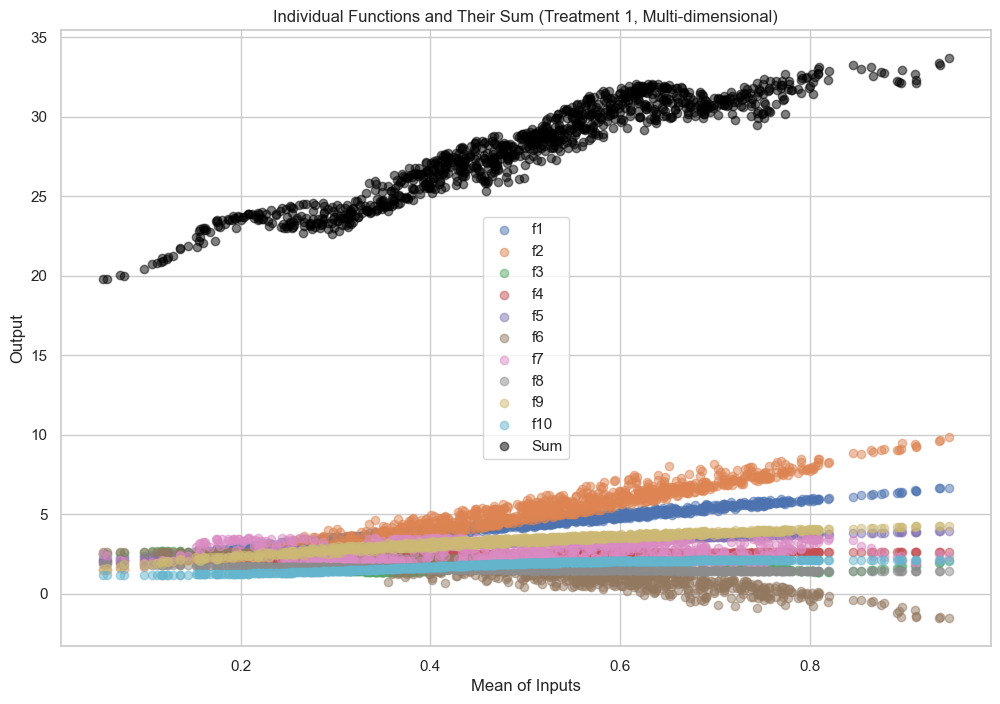

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def f1(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X, w[:Mj]) + w[-1]

def f2(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X**2, w[:Mj]) + np.dot(X, w[Mj:2*Mj]) + w[-1]

def f3(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (np.sin(np.pi * np.dot(X, w[1:Mj+1])) / 2 + 0.5) + w[-1]

def f4(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f5(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.sqrt(np.dot(X, w[1:Mj+1])) + w[-1]

def f6(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (1 - np.dot(X**3, w[1:Mj+1])) + w[-1]

def f7(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.cos(2 * np.pi * np.dot(X, w[1:Mj+1])) + 0.5) + w[-1]

def f8(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.exp(-np.dot(X, w[1:Mj+1])) / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f9(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.log(np.dot(X, w[1:Mj+1]) + 1) / np.log(2) + w[-1]

def f10(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.tanh(np.dot(X, w[1:Mj+1]) - 2) + 0.5) + w[-1]

def sample_weights(t, input_dim):
    np.random.seed(42)  # for reproducibility
    if t == 0:
        base = 0.5
        scale = 1.0
    else:
        base = 1.0
        scale = 1.0
    
    weights = []
    for _ in range(10):  # 10 functions
        w = np.random.uniform(base, base + scale, 2 * input_dim + 2)
        weights.append(w)
    
    return weights

def sum_function(inputs, weights):
    return sum(f(*inputs, w=w) for f, w in zip([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10], weights))

# Generate multi-dimensional inputs
input_dim = 3  # Change this to adjust the number of input dimensions
num_samples = 1000
inputs = np.random.rand(num_samples, input_dim)

# Plot functions for both treatments
plt.figure(figsize=(12, 8))

for t in [0, 1]:
    weights = sample_weights(t, input_dim)
    y = [sum_function(input_row, weights) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'Treatment {t}')

plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title('Sum of Functions for Different Treatments (Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Plot individual functions for a specific treatment
t = 1  # Change this to 0 or 1 to see different treatments
weights = sample_weights(t, input_dim)

plt.figure(figsize=(12, 8))
for i, func in enumerate([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]):
    y = [func(*input_row, w=weights[i]) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'f{i+1}')

y_sum = [sum_function(input_row, weights) for input_row in inputs]
plt.scatter(np.mean(inputs, axis=1), y_sum, alpha=0.5, label='Sum', color='black')
plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title(f'Individual Functions and Their Sum (Treatment {t}, Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Data Analysis

# Data baseline model 

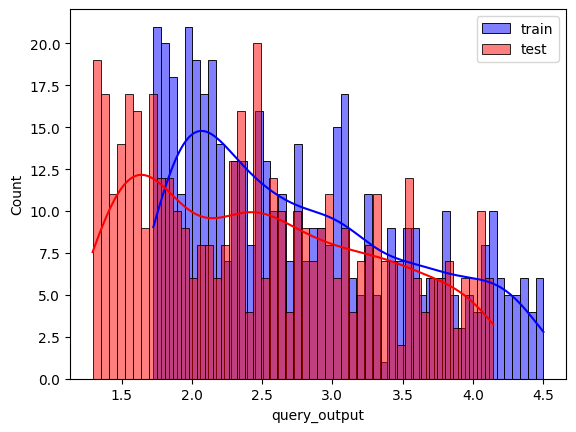

In [3]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

NameError: name 'baseline_combined_df' is not defined

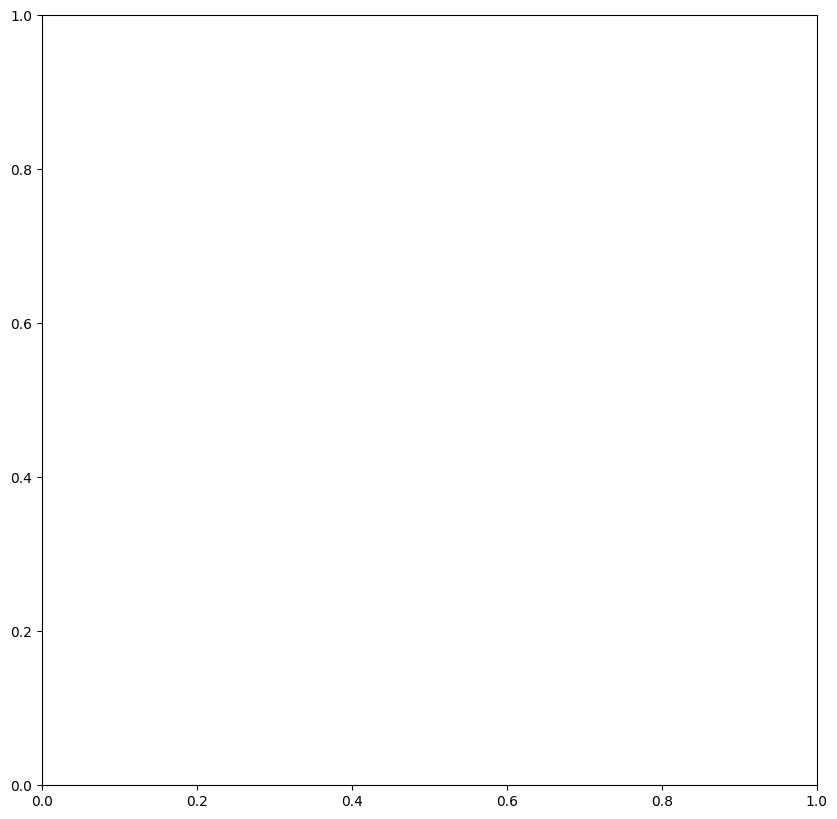

In [4]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

